# Multiobjective optimization using Kriging models

In this section, multiobjective optimization using Kriging models will be described. The idea in this section is to replace the true function with an accurate enough Kriging surrogate model and perform multiobjective optimization using the Kriging model. In this case, an accurate enough model is one that correctly describe the Pareto front of the problem in conjunction with an optimizer such as NSDE. The Kriging models used in this section are generated in much the same way as done in previous sections. 

The block of code below imports the required packages for this section.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from smt.sampling_methods import LHS, FullFactorial
from smt.surrogate_models import KRG
from pymoo.core.problem import Problem
from pymoo.optimize import minimize
from pymoode.algorithms import NSDE
from pymoode.survival import RankAndCrowding
from pymoo.util.nds.non_dominated_sorting import NonDominatedSorting
from pymoo.termination.default import DefaultMultiObjectiveTermination

## Branin-Currin optimization problem

The Branin-Currin optimization problem has been described in the previous section. The block of code below defines the two functions.

In [2]:
# Defining the objective functions
def branin(x):

    dim = x.ndim
    if dim == 1:
        x = x.reshape(1,-1)

    x1 = 15*x[:,0] - 5
    x2 = 15*x[:,1]

    b = 5.1 / (4*np.pi**2)
    c = 5 / np.pi
    t = 1 / (8*np.pi)

    y = (1/51.95)*((x2 - b*x1**2 + c*x1 - 6)**2 + 10*(1-t)*np.cos(x1) + 10 - 44.81)

    if dim == 1:
        y = y.reshape(-1)

    return y

def currin(x):

    dim = x.ndim
    if dim == 1:
        x = x.reshape(1,-1)

    x1 = x[:,0]
    x2 = x[:,1]
    
    factor = 1 - np.exp(-1/(2*x2))
    num = 2300*x1**3 + 1900*x1**2 + 2092*x1 + 60
    den = 100*x1**3 + 500*x1**2 + 4*x1 + 20
    y = factor*num/den
    
    if dim == 1:
        y = y.reshape(-1)

    return y

The block of code below solves the optimization problem directly using the true functions and NSDE. This will be used as a point of comparison when solving the problem using Kriging models. 

In [3]:
# Defining the problem class for pymoo - we are evaluating two objective functions in this case
class BraninCurrin(Problem):

    def __init__(self):
        super().__init__(n_var=2, n_obj=2, n_constr=0, xl=np.array([1e-6, 1e-6]), xu=np.array([1, 1]))

    def _evaluate(self, x, out, *args, **kwargs):

        out["F"] = np.column_stack((branin(x), currin(x)))

termination = DefaultMultiObjectiveTermination(
    xtol=1e-4,
    cvtol=1e-4,
    ftol=1e-4,
    period=30,
    n_max_gen=1000,
    n_max_evals=100000
)
problem = BraninCurrin()
algorithm = NSDE(pop_size=100, CR=0.9, survival=RankAndCrowding(crowding_func="pcd"), termination = termination, save_history = True)
res_true = minimize(problem, algorithm, verbose=False)

The next block of code defines a new problem class for solving the optimization problem using Kriging models. The problem class accepts two models, one for each function, as input arguments when initializing the class. 

After the definition of the problem class, a loop is utilized to iteratively create Kriging models for varying number of samples. Separte Kriging models are created for each of the objective functions. The optimization problem is solved using each of the Kriging models created and NSDE. Plots are created to compare the Pareto front obtained using the Kriging model and that obtained from the true function at each number of samples used. 

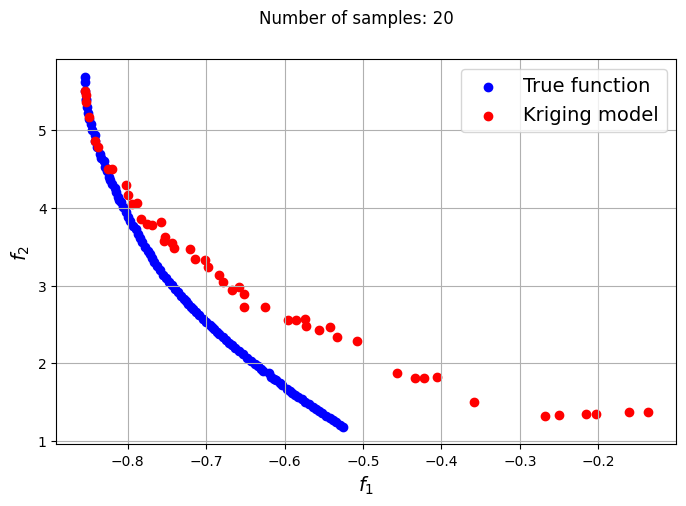

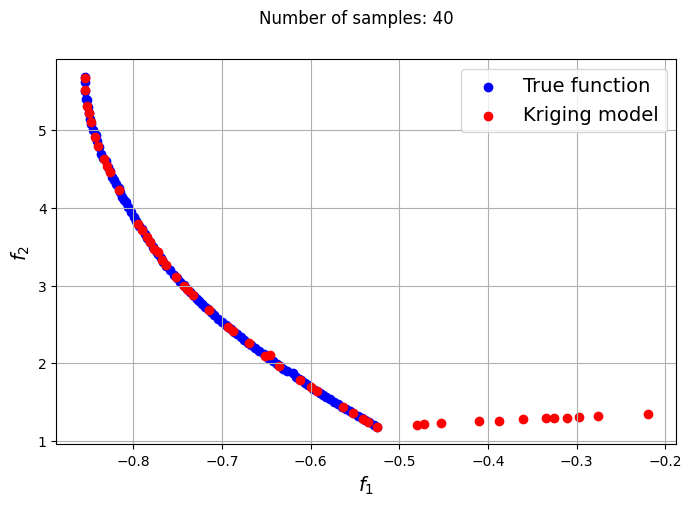

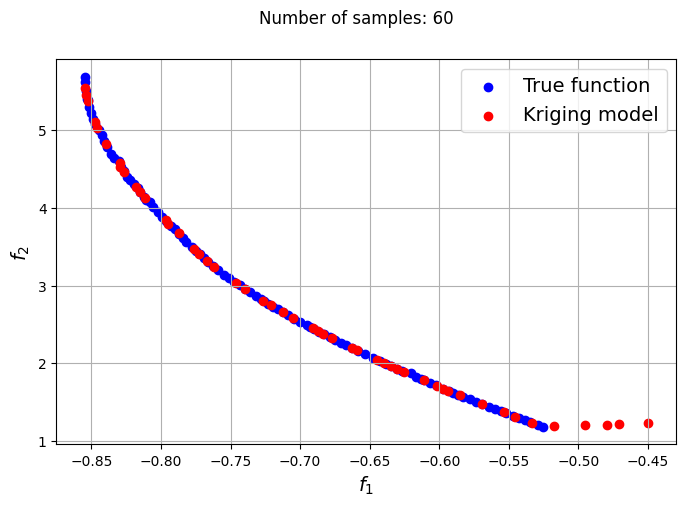

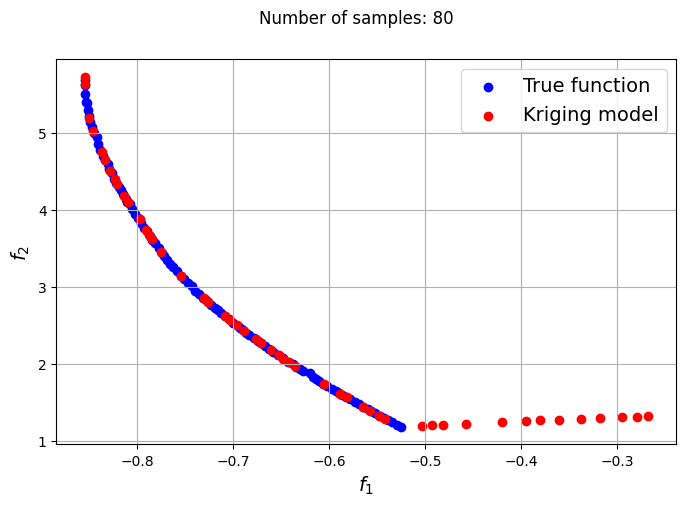

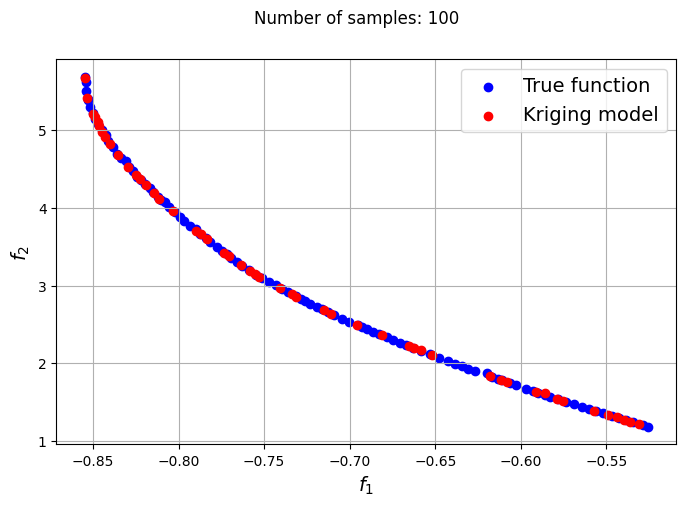

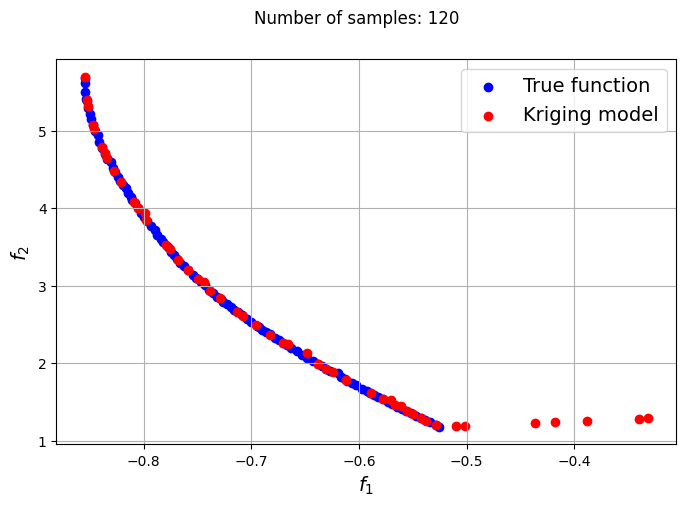

In [4]:
# Defining problem for kriging model based optimization
class KRGBraninCurrin(Problem):

    def __init__(self, sm_branin, sm_currin):
        super().__init__(n_var=2, n_obj=2, n_constr=0, xl=np.array([1e-6, 1e-6]), xu=np.array([1, 1]))
        self.sm_branin = sm_branin
        self.sm_currin = sm_currin

    def _evaluate(self, x, out, *args, **kwargs):

        out["F"] = np.column_stack((sm_branin.predict_values(x), sm_currin.predict_values(x)))

# Defining sample sizes
samples = np.arange(20,140,20)
xlimits = np.array([[1e-6,1.0],[1e-6,1.0]])

for size in samples:

    # Generate training samples using LHS
    sampling = LHS(xlimits=xlimits, criterion="ese")
    xtrain = sampling(size)
    ybranin = branin(xtrain)
    ycurrin = currin(xtrain)
    
    # Create kriging model
    corr = 'squar_exp'
    sm_branin = KRG(theta0=[1e-2], corr=corr, theta_bounds=[1e-6, 1e2], print_global=False)
    sm_branin.set_training_values(xtrain, ybranin)
    sm_branin.train()

    sm_currin = KRG(theta0=[1e-2], corr=corr, theta_bounds=[1e-6, 1e2], print_global=False)
    sm_currin.set_training_values(xtrain, ycurrin)
    sm_currin.train()

    problem = KRGBraninCurrin(sm_branin, sm_currin)
    algorithm = NSDE(pop_size=100, CR=0.9, survival=RankAndCrowding(crowding_func="pcd"), termination = termination, save_history = True)
    res_krg = minimize(problem, algorithm, verbose=False)

    F_krg = np.column_stack((branin(res_krg.X), currin(res_krg.X)))
    # Plotting final Pareto frontier obtained
    fig, ax = plt.subplots(figsize=(8, 5))
    ax.scatter(res_true.F[:, 0], res_true.F[:, 1], color="blue", label="True function")
    ax.scatter(F_krg[::2, 0], F_krg[::2, 1], color="red", label="Kriging model")
    ax.set_ylabel("$f_2$", fontsize = 14)
    ax.set_xlabel("$f_1$", fontsize = 14)
    ax.legend(fontsize = 14)
    ax.grid()
    fig.suptitle("Number of samples: {}".format(size))


The plots obtained from creating the various Kriging models show that approximately 100 samples are required to obtain an accurate enough representation of the Pareto front. Even though the Kriging models can be very accurate with a large number of samples, they can still produce certain solutions that lie outside of the Pareto front found using the true function. In most cases, these solutions are dominated solutions and should be ignored when plotting the Pareto front. This shows that it is indeed difficult to obtain an accurate Pareto front using surrogates when the problem involves complex multimodal functions.   

## Constrained multiobjective optimization problem

The constrained multiobjective optimization problem has been described previously. The block of code below defines the objective and constraint functions for the problem. After the definition of the functions, a Problem class is defined and the optimization problem is solved using NSDE and the true function. This solution will be used as a point of comparison for the surrogate-based methods.    

In [5]:
# Defining the objective functions
def f1(x):
    
    dim = x.ndim
    if dim == 1:
        x = x.reshape(1,-1)

    y = 4*x[:,0]**2 + 4*x[:,1]**2
    
    return y
    
def f2(x):

    dim = x.ndim
    if dim == 1:
        x = x.reshape(1,-1)

    y = (x[:,0]-5)**2 + (x[:,1]-5)**2

    return y

def g1(x):
    
    dim = x.ndim
    if dim == 1:
        x = x.reshape(1,-1)
    
    g = (x[:,0]-5)**2 + x[:,1]**2 - 25

    return g

def g2(x):

    dim = x.ndim
    if dim == 1:
        x = x.reshape(1,-1)
    
    g = 7.7 - ((x[:,0]-8)**2 + (x[:,1]+3)**2)

    return g

# Defining the problem class for pymoo - we are evaluating two objective and two constraint functions in this case
class ConstrainedProblem(Problem):

    def __init__(self):
        super().__init__(n_var=2, n_obj=2, n_ieq_constr=2, vtype=float)

        self.xl = np.array([-20.0, -20.0])
        self.xu = np.array([20.0, 20.0])

    def _evaluate(self, x, out, *args, **kwargs):

        out["F"] = np.column_stack([f1(x), f2(x)])
        out["G"] = np.column_stack([g1(x), g2(x)])

termination = DefaultMultiObjectiveTermination(
    xtol=1e-3,
    cvtol=1e-3,
    ftol=1e-3,
    period=30,
    n_max_gen=1000,
    n_max_evals=100000
)
problem = ConstrainedProblem()
nsde = NSDE(pop_size=100, CR=0.8, termination = termination, survival=RankAndCrowding(crowding_func="pcd"), save_history = True)
res_true = minimize(problem, nsde, verbose=False)

In the block of code below, a loop is utilized to iteratively create Kriging models for varying number of samples. The optimization problem is solved using each of the Kriging models created and NSDE. Separate Kriging models are created for each of the objective and constraint functions. This means the four Kriging models in total are created and used as input arguments for the new Problem class. Plots are created to compare the Pareto front obtained using the Kriging model and that obtained from the true function at each number of samples used. 

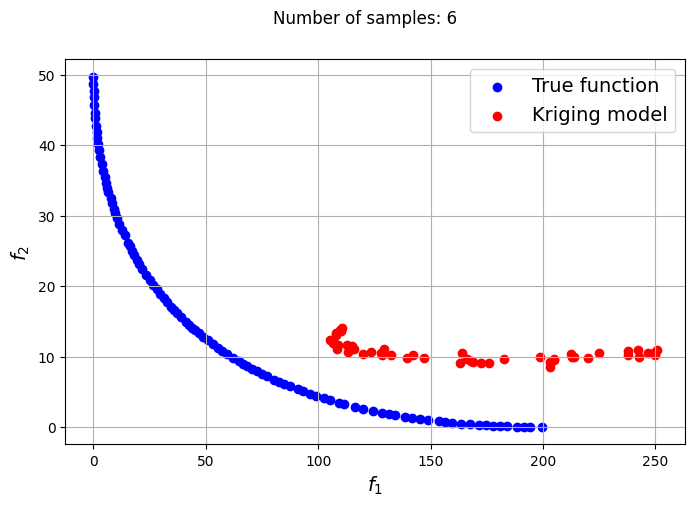

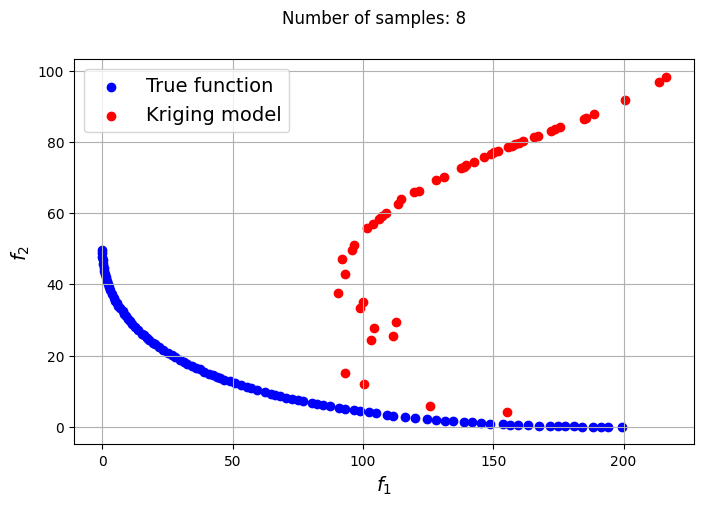

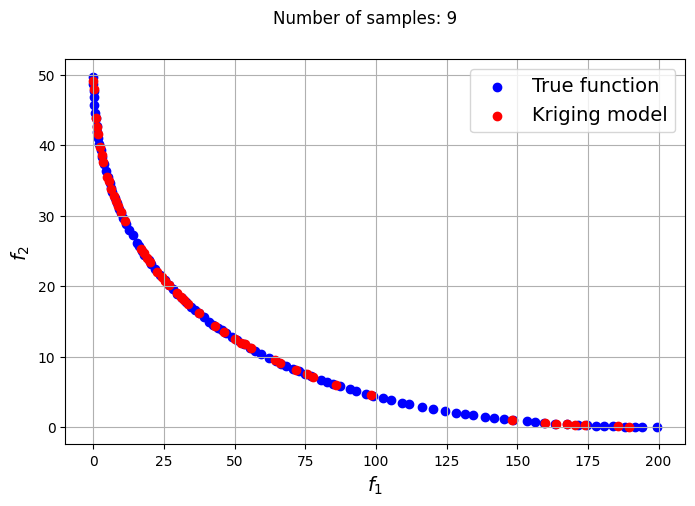

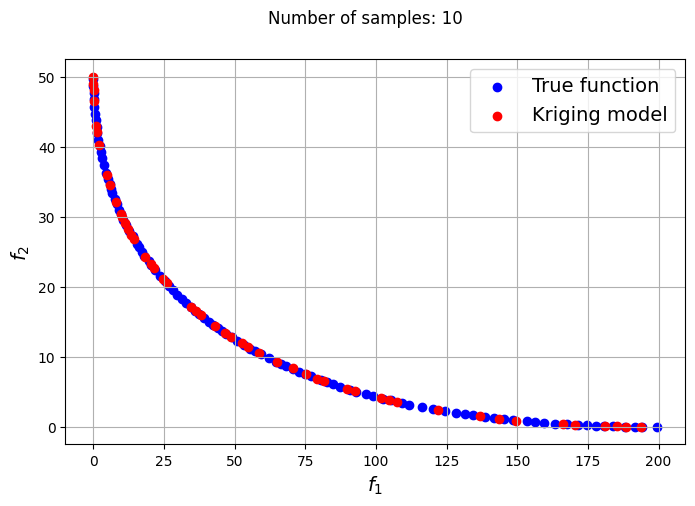

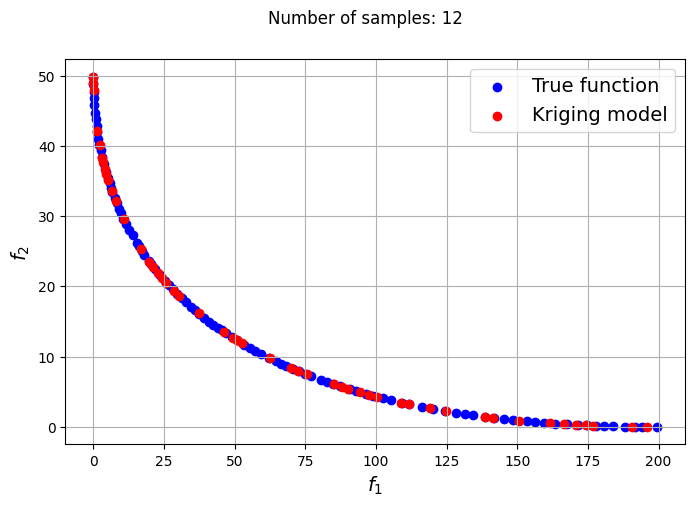

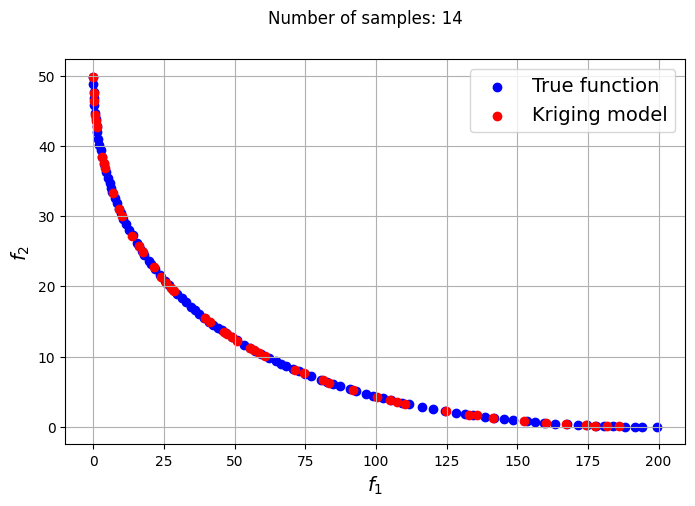

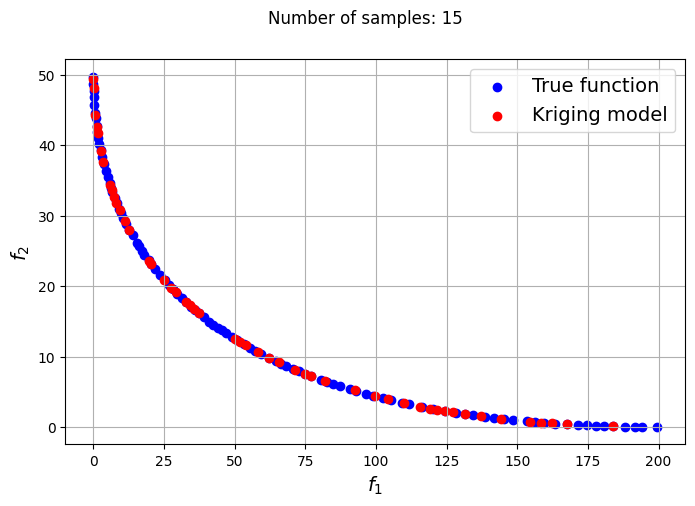

In [6]:
# Defining problem for kriging model based optimization
class KRGProb(Problem):

    def __init__(self, sm_f1, sm_f2, sm_g1, sm_g2):
        super().__init__(n_var=2, n_obj=2, n_ieq_constr=2, vtype=float)

        self.xl = np.array([-20.0, -20.0])
        self.xu = np.array([20.0, 20.0])

        self.sm_f1 = sm_f1
        self.sm_f2 = sm_f2
        self.sm_g1 = sm_g1
        self.sm_g2 = sm_g2

    def _evaluate(self, x, out, *args, **kwargs):

        F1 = self.sm_f1.predict_values(x)
        F2 = self.sm_f2.predict_values(x)
        
        G1 = self.sm_g1.predict_values(x)
        G2 = self.sm_g2.predict_values(x)
        
        out["F"] = np.column_stack((F1, F2))
        out["G"] = np.column_stack((G1, G2))

# Defining sample sizes
samples = [6,8,9,10,12,14,15]
xlimits = np.array([[-20.0,20.0],[-20.0,20.0]])

for size in samples:

    # Generate training samples using LHS
    sampling = LHS(xlimits=xlimits, criterion="ese")
    xtrain = sampling(size)
    yf1 = f1(xtrain)
    yf2 = f2(xtrain)
    yg1 = g1(xtrain)
    yg2 = g2(xtrain)
    
    # Create kriging model
    corr = 'squar_exp'
    sm_f1 = KRG(theta0=[1e-2], corr=corr, theta_bounds=[1e-6, 1e2], print_global=False)
    sm_f1.set_training_values(xtrain, yf1)
    sm_f1.train()

    sm_f2 = KRG(theta0=[1e-2], corr=corr, theta_bounds=[1e-6, 1e2], print_global=False)
    sm_f2.set_training_values(xtrain, yf2)
    sm_f2.train()
    
    sm_g1 = KRG(theta0=[1e-2], corr=corr, theta_bounds=[1e-6, 1e2], print_global=False)
    sm_g1.set_training_values(xtrain, yg1)
    sm_g1.train()

    sm_g2 = KRG(theta0=[1e-2], corr=corr, theta_bounds=[1e-6, 1e2], print_global=False)
    sm_g2.set_training_values(xtrain, yg2)
    sm_g2.train()

    problem = KRGProb(sm_f1, sm_f2, sm_g1, sm_g2)
    algorithm = NSDE(pop_size=100, CR=0.8, survival=RankAndCrowding(crowding_func="pcd"), termination = termination, save_history = True)
    res_krg = minimize(problem, algorithm, verbose=False)
    
    F_krg = np.column_stack((f1(res_krg.X), f2(res_krg.X)))
    # Plotting final Pareto frontier obtained
    fig, ax = plt.subplots(figsize=(8, 5))
    ax.scatter(res_true.F[:, 0], res_true.F[:, 1], color="blue", label="True function")
    ax.scatter(F_krg[::2, 0], F_krg[::2, 1], color="red", label="Kriging model")
    ax.set_ylabel("$f_2$", fontsize = 14)
    ax.set_xlabel("$f_1$", fontsize = 14)
    ax.legend(fontsize = 14)
    ax.grid()
    fig.suptitle("Number of samples: {}".format(size))


Owing to the simple nature of the functions used in this problem, only a few samples are required for the Kriging models to accurately obtain the Pareto front of the problem in conjunction with the NSDE algorithm. In such cases, surrogates prove to be useful tools for performing multiobjective optimization and require drastically lower evaluations of the true function to find the Pareto front. 